In [1]:
import numpy as np

In [28]:
pos = np.random.choice(20, 10, replace=False)
rev = 20 - pos

print("Positive numbers: ", pos)
print("Negative numbers: ", rev)

cs_pos = np.cumsum(pos)
cs_rev = np.cumsum(rev)
print("Cumulative sum of positive numbers: ", cs_pos)
print("Cumulative sum of negative numbers: ", cs_rev)

min_cs = np.minimum(cs_pos, cs_rev)
print("Minimum cumulative sum: ", min_cs)

choices = np.random.randint(3, 10, 10)
print("Choices: ", choices)

cs_ranks = []
ranks = []
b_ranks = []
for i in choices:
    rank = min(cs_pos[i - 1], cs_rev[i - 1])
    cs_ranks.append(rank)

    # Normal way
    rank = min(
        sum(pos[:i]),
        sum(rev[:i])
    )
    ranks.append(rank)

    # Brilliant way
    rank = min_cs[i - 1]
    b_ranks.append(rank)

print("cs_ranks", cs_ranks)
print("ranks   ", ranks)
print("b_ranks ", b_ranks)


Positive numbers:  [ 7  5 11 14  9  8  1  6 13 15]
Negative numbers:  [13 15  9  6 11 12 19 14  7  5]
Cumulative sum of positive numbers:  [ 7 12 23 37 46 54 55 61 74 89]
Cumulative sum of negative numbers:  [ 13  28  37  43  54  66  85  99 106 111]
Minimum cumulative sum:  [ 7 12 23 37 46 54 55 61 74 89]
Choices:  [8 9 9 3 5 5 5 7 6 5]
cs_ranks [61, 74, 74, 23, 46, 46, 46, 55, 54, 46]
ranks    [61, 74, 74, 23, 46, 46, 46, 55, 54, 46]
b_ranks  [61, 74, 74, 23, 46, 46, 46, 55, 54, 46]


In [4]:
import sys
from timeit import default_timer as timer

import numpy as np
import pandas as pd


def main(cp_file: str, de_file: str, iters: int):
    """
    :param cp_file: File path of causal-priors file
    :param de_file: File path of differential-exp file
    :param iters: Number of iterations
    :return:
    """
    if cp_file is None or de_file is None:
        print('Please provide causal-priors and differential-exp file path')
        sys.exit(1)

    if not isinstance(cp_file, str) or not isinstance(de_file, str):
        print('Please provide causal-priors and differential-exp file path as string')
        sys.exit(1)

    try:
        cp_df = pd.read_csv(cp_file, sep='\t', header=None)
        cp_df.columns = ['Symbols', 'action', 'targetSymbol', 'reference', 'residual']
        cp_df = cp_df.drop(['reference', 'residual'], axis=1)
        cp_df = cp_df[cp_df['action'].isin(['upregulates-expression', 'downregulates-expression'])]
        cp_df = cp_df.reset_index(drop=True)

        de_df = pd.read_csv(de_file, sep='\t')

        # Create a new column named updown based on positive
        # and negative values of SignedP column of de_df dataframe
        de_df['updown'] = np.where(de_df['SignedP'] > 0, '1', '-1')

        # Sort SignedP column in ascending order if updown column is 1
        # and sort absolute values of SignedP column in ascending order if updown column is -1
        de_df = de_df.sort_values(by=['updown', 'SignedP'], ascending=[False, True])

        # Remove rows of cp_df dataframe if targetSymbol is not present in Symbols column of rank_df dataframe
        cp_df = cp_df[cp_df['targetSymbol'].isin(de_df['Symbols'])]
        # Reset index
        cp_df = cp_df.reset_index(drop=True)

        # Find the max rank
        max_rank = len(de_df) - 1
        de_df['rank'] = np.arange(max_rank + 1)
        de_df['reverse_rank'] = max_rank - de_df['rank']

        # Represent upregulates-expression as 1 and downregulates-expression as -1
        cp_df['isUp'] = np.where(cp_df['action'] == 'upregulates-expression', 1, -1)
        cp_df.drop(['action'], axis=1, inplace=True)

        # Find the rank and reverse rank of targetSymbols
        cp_df['rank'] = cp_df['targetSymbol'].apply(lambda x: de_df[de_df['Symbols'] == x]['rank'].values[0])
        cp_df['revRank'] = max_rank - cp_df['rank']

        # Calculate the actual rank sum of each Symbol for positive and negative ranks
        rank_sum_df = cp_df.groupby('Symbols').apply(
            lambda x: x[x['isUp'] == 1]['rank'].sum() + x[x['isUp'] == -1][
                'revRank'].sum()).reset_index(name='posRS')
        rank_sum_df['negRS'] = cp_df.groupby('Symbols').apply(
            lambda x: x[x['isUp'] == 1]['revRank'].sum() + x[x['isUp'] == -1][
                'rank'].sum()).reset_index(name='negRS')['negRS']

        # Chose value between column posRS and negRS and also find column choosed and store it in a new column
        rank_sum_df['RS'] = np.where(rank_sum_df['posRS'] < rank_sum_df['negRS'], rank_sum_df['posRS'],
                                     rank_sum_df['negRS'])
        rank_sum_df['whichRS'] = np.where(rank_sum_df['posRS'] < rank_sum_df['negRS'], 'posRS', 'negRS')

        # Create a new dataframe with key: Symbols and value: List of 1's and -1's
        output_df = cp_df.groupby('Symbols')['isUp'].apply(list).reset_index(name='upDownList')
        # Count the number of 1's and -1's in upDownList column and store it in a new column
        output_df['upDownCount'] = output_df['upDownList'].apply(lambda x: len(x))
        # Remove rows from output_df dataframe if upDownCount is less than 3
        output_df = output_df[output_df['upDownCount'] >= 3]

        # Find column RS, whichRS from rank_sum_df and merge it with output_df dataframe
        output_df = output_df.merge(rank_sum_df[['Symbols', 'RS', 'whichRS']], on='Symbols', how='left')

        # Find maximum number of targets for a Symbol
        max_target = np.max(output_df['upDownCount'])

        output_df['rankLessThanActual'] = 0
        uniqueUpDowns = output_df['upDownCount'].unique()

        # Initialize the array to store results
        result = np.zeros((len(uniqueUpDowns), iters))

        loop_start = timer()
        for i in range(iters):
            # Draw a random number from 0 to max_rank+1
            drawn_list = np.random.choice(max_rank + 1, max_target, replace=False)
            reverse_drawn_list = max_rank - drawn_list
            min_rank_sum = np.minimum(np.cumsum(drawn_list), np.cumsum(reverse_drawn_list))
            result[:, i] = [min_rank_sum[x - 1] for x in uniqueUpDowns]

        loop_end = timer()
        print(f'Loop took {loop_end - loop_start} seconds')

        # Merge all columns of results_array into a list of values
        result = pd.DataFrame(result).apply(lambda x: x.values.tolist(), axis=1)
        df_result = pd.concat([pd.DataFrame(uniqueUpDowns), result], axis=1)
        df_result.columns = ['totalCount', 'rank_sum_list']

        # Merge output_df and df_result dataframe
        output_df['RSList'] = output_df['upDownCount'].apply(
            lambda x: df_result[df_result['totalCount'] == x]['rank_sum_list'].values[0])

        # Count the number of times RS is less than RSList
        output_df['rankLessThanActual'] = output_df.apply(lambda x: np.sum(np.array(x['RSList']) < x['RS']), axis=1)
        output_df['rankLessThanActual'] = 1 + output_df['rankLessThanActual']
        output_df.drop(['RSList'], axis=1, inplace=True)

        # Calculate the p-value
        output_df['pValue'] = output_df['rankLessThanActual'] / iters

        # Save the output dataframe to a file
        output_df.to_csv('../output/ultimate_output.tsv', sep='\t', index=False)

    except FileNotFoundError:
        print('File not found: ', cp_file)
        sys.exit(1)

    except Exception as e:
        print(e)
        sys.exit(1)


if __name__ == '__main__':
    priors_file = '../data/causal-priors.txt'
    diff_file = '../data/differential-exp.tsv'
    # diff_file = '../data/rslp_vs_lum.tsv'

    start = timer()
    main(priors_file, diff_file, iters=5_000)
    end = timer()
    print("Time taken: ", end - start)


Loop took 0.27842108299955726 seconds
Time taken:  2.9773218340124004


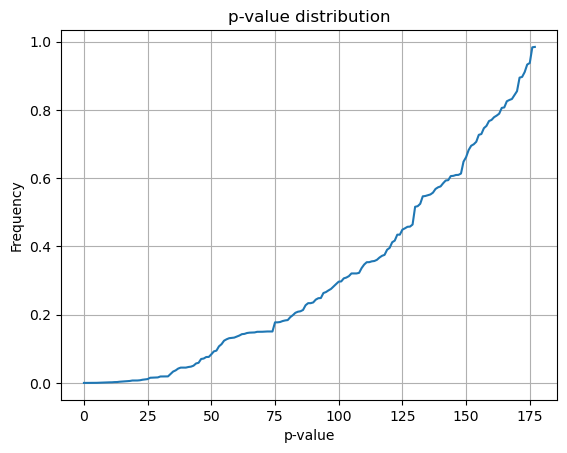

In [77]:
import matplotlib.pyplot as plt

df = pd.read_csv('../output/ultimate_output.tsv', sep='\t')

pValues = df['pValue']

# Sort p-values in ascending order
pValues = np.sort(pValues)

# Plot p-value distribution
plt.plot(pValues)
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('p-value distribution')
plt.grid(True)
plt.show()


In [4]:
import numpy as np

a = [1,2,3]
b = [4,5]

c = np.concatenate((a,b))

print(c)

[1 2 3 4 5]


In [2]:
# Generate 10000 x and y random coordinates\
import numpy as np
x = np.random.rand(100)
y = np.random.rand(100)

x

array([0.17208747, 0.02942356, 0.68779811, 0.19981303, 0.94164931,
       0.62411261, 0.38648211, 0.85975074, 0.05945706, 0.37306923,
       0.93838873, 0.7544772 , 0.50671711, 0.74196987, 0.21939959,
       0.24348819, 0.86464994, 0.59082455, 0.27045048, 0.11027186,
       0.16683168, 0.31762014, 0.72198751, 0.81169965, 0.5252285 ,
       0.22590772, 0.96454932, 0.58380668, 0.18808184, 0.45426328,
       0.92075774, 0.26146417, 0.19603822, 0.30761814, 0.8084049 ,
       0.40080963, 0.43673722, 0.92346999, 0.84942175, 0.94302334,
       0.63124892, 0.8687741 , 0.01137181, 0.11680462, 0.77050416,
       0.1513501 , 0.72437899, 0.13662179, 0.82193443, 0.74557943,
       0.23746772, 0.2580905 , 0.99927806, 0.69117257, 0.46788413,
       0.79813545, 0.89809763, 0.61029341, 0.39439079, 0.55600967,
       0.2103519 , 0.751231  , 0.85795062, 0.10025538, 0.4131031 ,
       0.61935464, 0.6314928 , 0.70459173, 0.7323075 , 0.92606709,
       0.4387646 , 0.90012647, 0.24175518, 0.63601269, 0.64629